In [5]:
import numpy as np
from lattice_actions import get_neighbors, get_neighbors_kdtree
from fibonacci import generate_vertices, generate_vertices_angles, generate_vertices_angles_mp
from multiprocessing import Pool
from lattice_optimisation import lattice_optimizer, angles_to_cartesian
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots
import pickle

CPU_CORES = 16

In [6]:
from math import sqrt, sin, cos
import math

from pynverse import inversefunc

from pathos.pools import ProcessPool

from mpmath import mp

#import rpy2.robjects as robjects
#import rpy2.robjects.numpy2ri

import gmpy2

mp.dps = 100


def getFCCDist(n, d):
    if d != 3:
        print("no other than 3d case implemented")
        exit(-1)

    return ((4.0 / n) ** (1.0 / d)) / sqrt(2)


def estimatePointSpread(n, a):

    a = np.array(a)

    d = len(a) + 1

    minDist = d
    angle = mp.pi

    for p in range(1, int(n * getFCCDist(n, d)) + 3):
        diffs = (p * a) % 1
        for i, df in enumerate(diffs):
            if df > 0.5:
                diffs[i] = 1 - df

        dist = mp.sqrt((p / n) ** 2 + np.sum(diffs**2))

        if minDist > dist:
            minDist = dist
            angle = np.arccos(p / (n * float(dist)))

    # Only holds for d=3
    return minDist / getFCCDist(n, d), angle  # , pMin

memo = {}
memo[2] = 3

def findOptimalFibCoefficients(
    N,
    distThresh=0.95,
    angCenter=1.2,  # 0.7853981633974483096,
    angEps=0.1,
):
    p1, p2 = 2, 3
    memo[2] = 3

    while True:

        dist, ang = estimatePointSpread(N, [mp.sqrt(p1), mp.sqrt(p2)])

        if (dist > distThresh) and (abs(ang - angCenter) < angEps):
            return [mp.sqrt(p1), mp.sqrt(p2)]

        if memo[p1] == p2:
            p1 = 2
            if p2 not in memo:
                memo[p2] = int(gmpy2.next_prime(p2))
            p2 = memo[p2]
        else:
            p1 = memo[p1]



def getFibPoints(
    N,
    a=None,
    distThresh=0.95,
    angCenter=1.2,  # 0.7853981633974483096,
    angEps=0.1,
):

    # Finding good irrational numbers
    if a == -1:
        a = findOptimalFibCoefficients(N, distThresh, angCenter, angEps)
        print(f"-- got irrationals for {N} --")


    def getCartesianCoords(psi, theta, phi):
        return np.array(
            [
                cos(psi),
                sin(psi) * cos(theta),
                sin(psi) * sin(theta) * cos(phi),
                sin(psi) * sin(theta) * sin(phi),
            ]
        )

    # for n in range(N):
    def generatePoint(n):
        # Calculating Psi
        ps = inversefunc(
            lambda x: (x - (0.5 * sin(2 * x))), y_values=(math.pi * n) / (N)
        )

        # Calculating Theta
        th = mp.acos(1 - (2 * ((n * a[0]) % 1)))

        # Calculating Phi
        ph = 2 * mp.pi * ((n * a[1]) % 1)

        # out[n, :] = getCartesianCoords(ps, th, ph)
        return ps, float(th), float(ph)

    out = generate_vertices_angles_mp(N, irr = [float(a[0]), float(a[1])])
    #for i in range(N):
    #    out.append(generatePoint(i))

    
    return np.array(out)

In [7]:
def wrap_getFibPoints(dat):
        return getFibPoints(dat[0], a = dat[1])

def wrap_get_Vertices_angles(dat):
    return generate_vertices_angles(dat[0], irr = dat[1])

def compare_optimization(number_of_partitions : int, Start = 2**5, End = 2**15, irationals=None):

    irationals = -1 if irationals == None else irationals

    numbers = np.geomspace(Start, End, number_of_partitions, dtype=int, endpoint=True)
    angle_lattices = []
    if irationals == -1:
        for number in numbers:
            angle_lattices.append(wrap_getFibPoints([number, irationals]))
    else:
        for number in numbers:
            angle_lattices.append(generate_vertices_angles_mp(number, irr = irationals))
    print("-- angles done --")
    pool = Pool(CPU_CORES)
    opt_lattices_res = pool.map(lattice_optimizer, angle_lattices, chunksize=int(number_of_partitions/(CPU_CORES*2) + 1))
    
    return numbers, angle_lattices, opt_lattices_res

In [4]:
num = 100

numbers, angles, res = compare_optimization(num, End = 2**20)
with open("prime_opt_lattices.pickle", "wb") as file:
    pickle.dump(res, file)

-- got irrationals for 32 --
-- got irrationals for 35 --
-- got irrationals for 39 --
-- got irrationals for 43 --
-- got irrationals for 48 --
-- got irrationals for 54 --
-- got irrationals for 60 --
-- got irrationals for 66 --
-- got irrationals for 74 --
-- got irrationals for 82 --
-- got irrationals for 91 --
-- got irrationals for 101 --
-- got irrationals for 112 --
-- got irrationals for 125 --
-- got irrationals for 139 --
-- got irrationals for 154 --
-- got irrationals for 171 --
-- got irrationals for 190 --
-- got irrationals for 211 --
-- got irrationals for 235 --
-- got irrationals for 261 --
-- got irrationals for 290 --
-- got irrationals for 322 --
-- got irrationals for 358 --
-- got irrationals for 397 --
-- got irrationals for 441 --
-- got irrationals for 490 --
-- got irrationals for 545 --
-- got irrationals for 605 --
-- got irrationals for 672 --
-- got irrationals for 747 --
-- got irrationals for 830 --
-- got irrationals for 921 --
-- got irrationals fo

In [8]:
num = 100

#for arr in angles:
#    np.save(f"lattices\prime_optimised_angles_{arr.shape[0]}", arr)
prime_optimized_angles = []
for n in np.geomspace(2**5, 2**18, num, dtype=int, endpoint=True):
    prime_optimized_angles.append(np.load(f"lattices\prime_optimised_angles_{n}.npy"))

In [9]:
#pool = Pool(CPU_CORES)
#opt_lattices_res = pool.map(lattice_optimizer, prime_optimized_angles, chunksize=int(num/(CPU_CORES*2) + 1))

In [10]:
#with open("prime_opt_lattices.pickle", "wb") as file:
#    pickle.dump(opt_lattices_res, file)
with open("prime_opt_lattices.pickle", "rb") as file:
    prime_opt_lattices_res = pickle.load(file)

In [22]:

numbers = np.geomspace(2**5, 2**20, num, dtype=int, endpoint=True)
prime_optimised = []
prime_optimised_sig = []
for data in prime_opt_lattices_res:
    prime_optimised.append(data[1] - data[2][0])
    prime_optimised_sig.append(data[3][0])

In [12]:
num = 100

numbers, angles, res = compare_optimization(num, End = 2**20, irationals=[np.sqrt(2), np.sqrt(3)])

-- angles done --


In [13]:


normal_optimised = []
for data in res:
    normal_optimised.append(data[1] - data[2][0])

In [14]:
num = 100
numbers, angles, res = compare_optimization(num, End = 2**20, irationals=[np.sqrt(3), np.sqrt(5)])

p3_p5_optimised = []
for data in res:
    p3_p5_optimised.append(data[1] - data[2][0])

-- angles done --


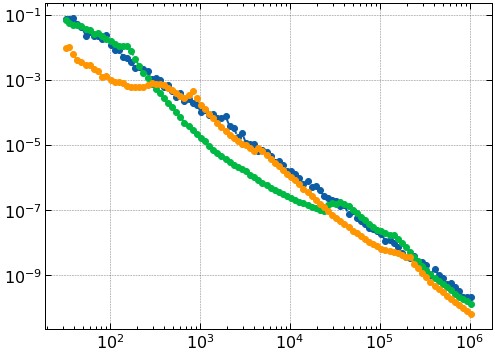

In [24]:
numbers = np.geomspace(2**5, 2**20, num, dtype=int, endpoint=True)
plt.plot(numbers, prime_optimised, "o--")
#plt.fill_between(numbers, np.array(prime_optimised)-np.array(prime_optimised_sig), np.array(prime_optimised)+np.array(prime_optimised_sig), )
plt.plot(numbers, normal_optimised, "o--")
plt.plot(numbers, p3_p5_optimised, "o--")

plt.xscale("log")
plt.yscale("log")


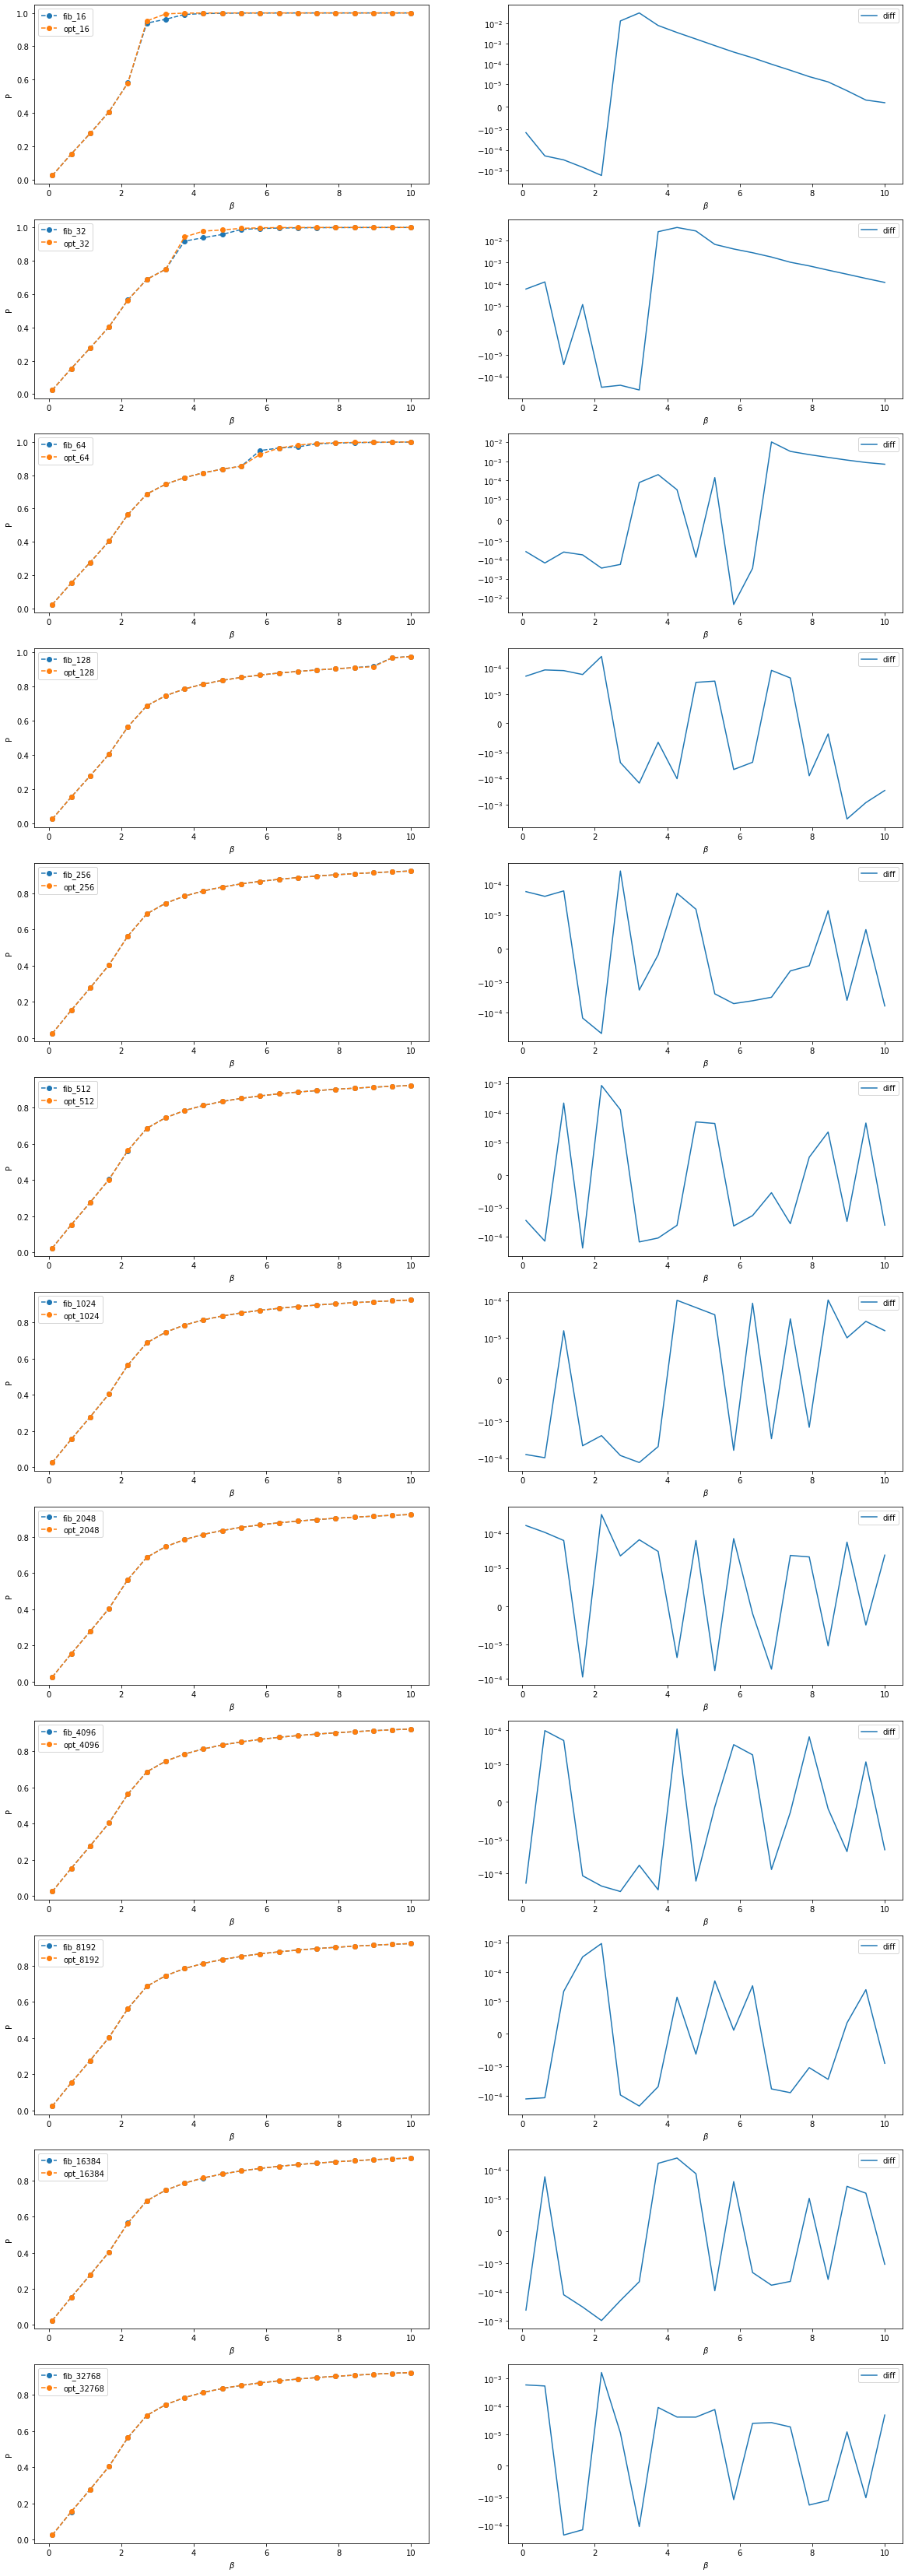

In [2]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt

def P_ref(beta):
    ''' 
    generates P_ref according to the strong and weak coupling expansion
    '''
    P = 0
    if beta < 1.21:
        koeffs = [1/4, -1/96, 7/1536, -31/23040, 4451/8847360, 
                    -264883/1486356480, 403651/5945425920,
                    -1826017873/68491306598400]
        for i in range(0,8):
            P += koeffs[i]*beta**(2*i-1)
    else:
        koeffs = [0.7498,0.1511,0.1427,0.1747,0.2435,0.368,0.5884,
                    0.98,1.6839,2.9652,5.326,9.7234,17.995,33.690,63.702]
        for i in range(1,16):
            P += koeffs[i-1]/beta**i
    return P


betas = np.linspace(0.1,10,20)
P_r = [P_ref(beta) for beta in betas]


path = pathlib.Path("su2mc_cpp/tmp_7000sweeps_5000thrown")

#np.loadtxt("fib_16.csv")
fig, axes = plt.subplots(12,2,figsize=(20,60))
for i in range(4,16):
    ax1 = axes[i-4][0]
    ax2 = axes[i-4][1]
    fib = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(1))
    fib_sig = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(2))
    opt = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(1))
    opt_sig = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(2))
    
    ax1.plot(betas, fib, "o--", label=f"fib_{2**i}")
    ax1.plot(betas, opt, "o--", label=f"opt_{2**i}")
    ax2.plot(betas, (opt-fib), label="diff")
    ax2.set_yscale("symlog", linthresh=1e-5)
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax1.set_xlabel(r"$\beta$")
    ax1.set_ylabel(r"P")
    ax2.set_xlabel(r"$\beta$")
plt.show()

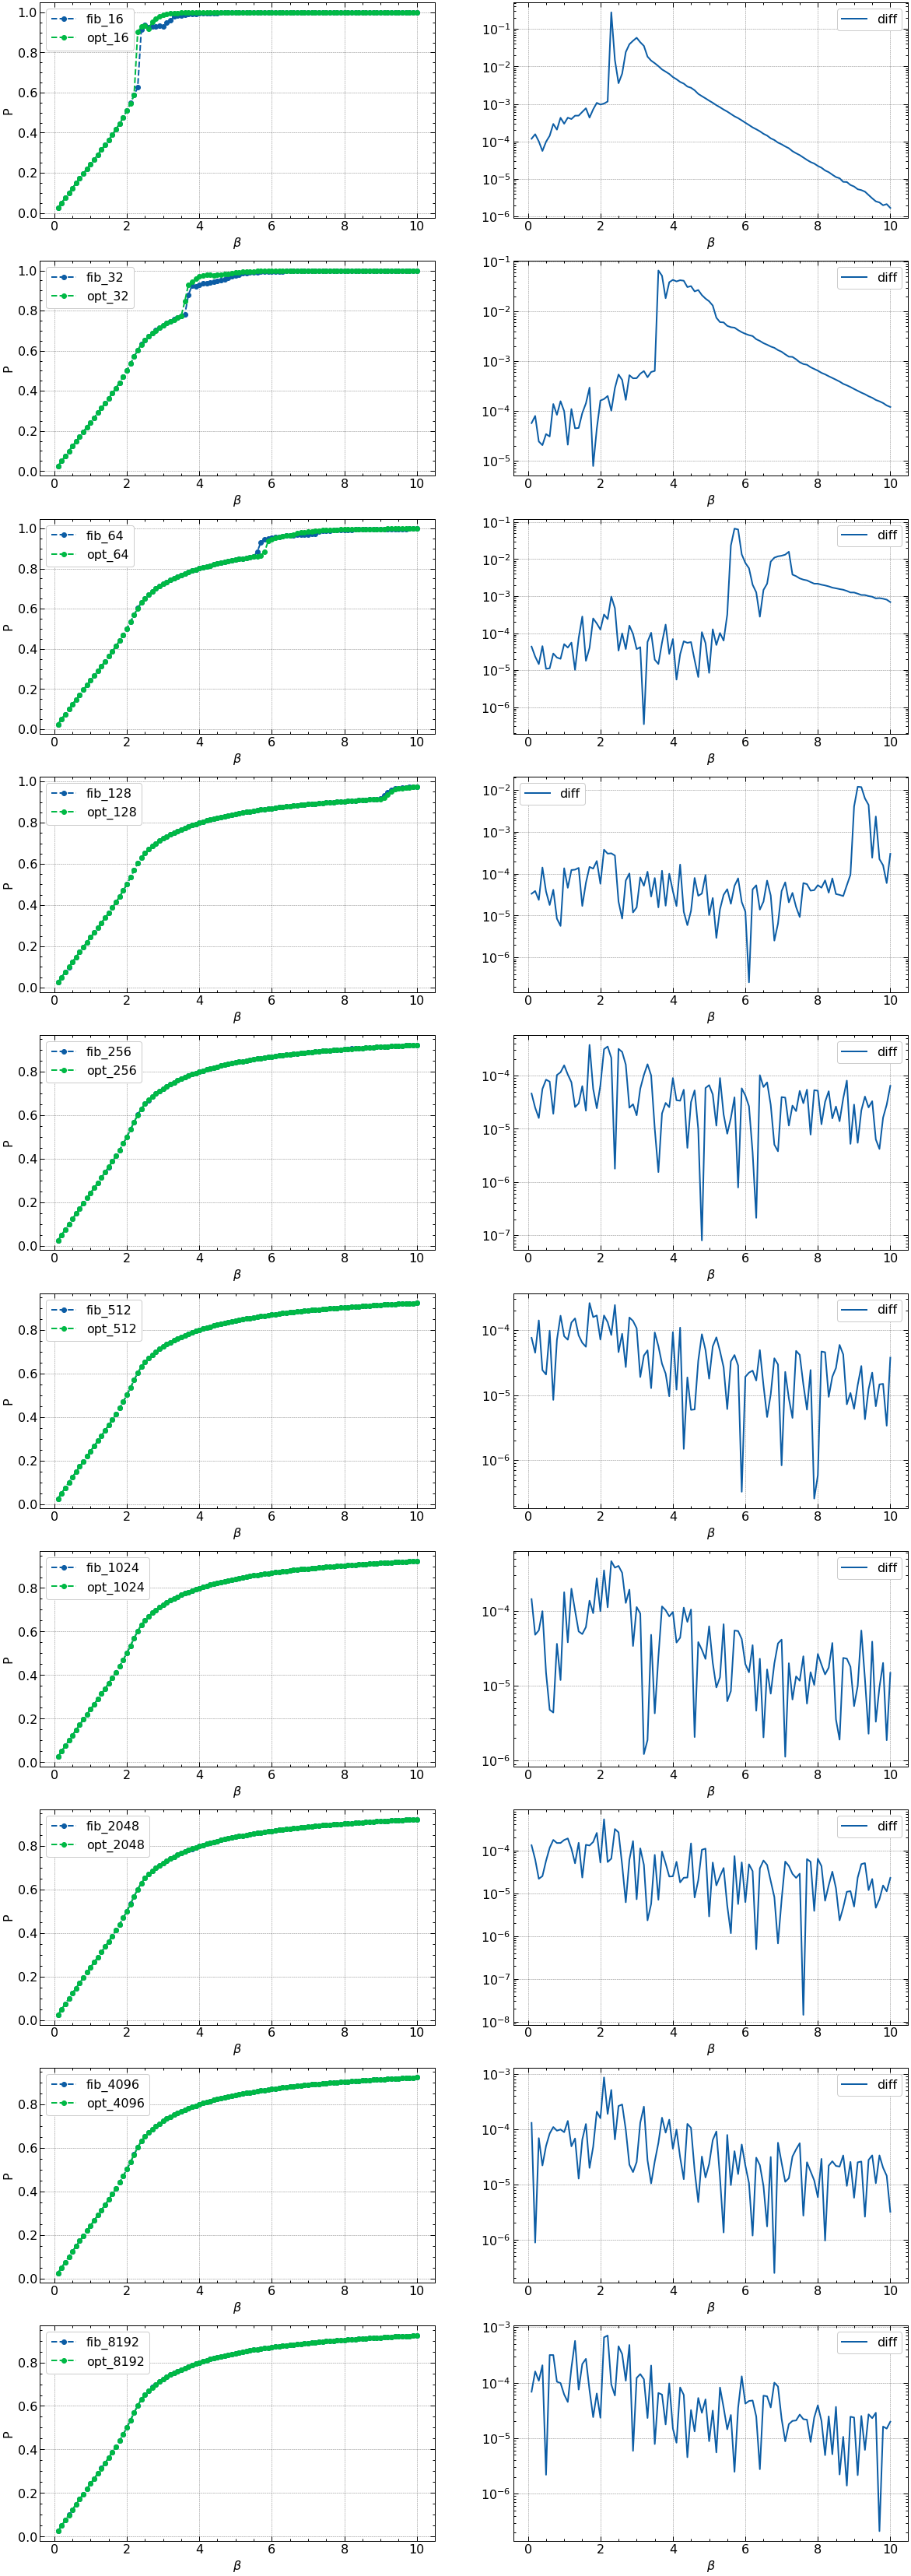

In [1]:
import pathlib 
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['science', 'notebook', 'grid']) #dependency: SciencePlots

def P_ref(beta):
    ''' 
    generates P_ref according to the strong and weak coupling expansion
    '''
    P = 0
    if beta < 1.21:
        koeffs = [1/4, -1/96, 7/1536, -31/23040, 4451/8847360, 
                    -264883/1486356480, 403651/5945425920,
                    -1826017873/68491306598400]
        for i in range(0,8):
            P += koeffs[i]*beta**(2*i-1)
    else:
        koeffs = [0.7498,0.1511,0.1427,0.1747,0.2435,0.368,0.5884,
                    0.98,1.6839,2.9652,5.326,9.7234,17.995,33.690,63.702]
        for i in range(1,16):
            P += koeffs[i-1]/beta**i
    return P


betas = np.linspace(0.1,10,100)
P_r = [P_ref(beta) for beta in betas]


path = pathlib.Path("su2mc_cpp/tmp_8000sweeps_5000thrown_fine")

#np.loadtxt("fib_16.csv")
fig, axes = plt.subplots(10,2,figsize=(20,60))
for i in range(4,14):
    ax1 = axes[i-4][0]
    ax2 = axes[i-4][1]
    fib = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(1))
    fib_sig = np.loadtxt(list(path.glob(f"**/fib*{2**i}.csv"))[0], usecols=(2))
    opt = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(1))
    opt_sig = np.loadtxt(list(path.glob(f"**/opt*{2**i}.csv"))[0], usecols=(2))
    
    ax1.plot(betas, fib, "o--", label=f"fib_{2**i}")
    ax1.plot(betas, opt, "o--", label=f"opt_{2**i}")
    ax2.plot(betas, abs(opt-fib), label="diff")
    #ax2.set_yscale("symlog", linthresh=1e-5)
    ax2.set_yscale("log")#, linthresh=1e-5)
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax1.set_xlabel(r"$\beta$")
    ax1.set_ylabel(r"P")
    ax2.set_xlabel(r"$\beta$")
plt.show()